In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:75% !important; }</style>"))

In [2]:
import sys

sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

import numpy as np

# Import PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# # Import TensorLy
# import tensorly as tl
# from tensorly.tucker_tensor import tucker_to_tensor
# from tensorly.random import check_random_state

In [3]:
sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

import tensorly as tl
import tensorly.decomposition
import tensorly.random


In [4]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import tensorly; print("TensorLy", tensorly.__version__)
import torch; print("PyTorch", torch.__version__)

Linux-5.4.0-54-generic-x86_64-with-glibc2.10
Python 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
NumPy 1.19.2
SciPy 1.5.2
TensorLy 0.5.0
PyTorch 1.7.0


In [5]:
tl.set_backend('pytorch')

Make the results reproducible by fixing the random seed

In [6]:
random_state = 1234
rng = tensorly.random.check_random_state(random_state)
device = 'cuda:0'
# device = 'cpu'

In [7]:
### import data

dir_factors_np = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
fileName_factors_np = f'factors_np.npy'
path_factors_np = f'{dir_factors_np}/{fileName_factors_np}'
factors_np = np.load(path_factors_np , allow_pickle=True)
print(f'inputTensor shape: {factors_np.shape}')

inputTensor shape: (4,)


In [8]:
### import data

dir_inputTensor = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
fileName_inputTensor = f'Sxx_allPixels.npy'
path_inputTensor = f'{dir_inputTensor}/{fileName_inputTensor}'
inputTensor = np.load(path_inputTensor)
print(f'inputTensor shape: {inputTensor.shape}')

inputTensor shape: (820, 49, 29323, 2)


In [9]:
tensor = tl.tensor(inputTensor[:,:,:4500, :] , device=device , dtype=tl.float32 , requires_grad=True)
# tensor = tl.tensor(tensor[ , device=device , requires_grad=True)

import gc

del inputTensor
gc.collect()

In [10]:
rank_toUse = 6
ranks = [rank_toUse , rank_toUse, rank_toUse , rank_toUse]
# core = tl.tensor(rng.random_sample(ranks), device=device, requires_grad=True)

# factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])),
#                  device=device, requires_grad=True) for i in range(tl.ndim(tensor))]

weights = tl.tensor(np.ones(rank_toUse) , device=device, dtype=tl.float32, requires_grad=True)

In [41]:
#basic libary
import torch

import torch.nn as nn
import torch.optim as optim

##Define Function and class to be used
eps = 1.3e-7  # Slightly higher than min value of fp32
prox_plus = nn.Threshold(0,eps) ## to make all output postive 

class NTF(nn.Module): ## Model
    def __init__(self):
        super(NTF, self).__init__()

#         self.factors = nn.ParameterList([nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[i], ranks[i])) , device='cuda:0').double(), requires_grad=True) for i in range(tensor.ndim)])
        
#         self.factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])), device='cuda:0', requires_grad=True) for i in range(tl.ndim(tensor))]

        self.factors1 = nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[0], ranks[0])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
        self.factors2 = nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[1], ranks[1])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
        self.factors3 = nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[2], ranks[2])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
        self.factors4 = nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[3], ranks[3])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
        
#         self.factors1 = Variable(torch.tensor(rng.random_sample((tensor.shape[0], ranks[0])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
#         self.factors2 = Variable(torch.tensor(rng.random_sample((tensor.shape[1], ranks[1])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
#         self.factors3 = Variable(torch.tensor(rng.random_sample((tensor.shape[2], ranks[2])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
#         self.factors4 = Variable(torch.tensor(rng.random_sample((tensor.shape[3], ranks[3])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 

#         self.factors1 = torch.tensor(rng.random_sample((tensor.shape[0], ranks[0])) , device='cuda:0', requires_grad=True) 
#         self.factors2 = torch.tensor(rng.random_sample((tensor.shape[1], ranks[1])) , device='cuda:0', requires_grad=True) 
#         self.factors3 = torch.tensor(rng.random_sample((tensor.shape[2], ranks[2])) , device='cuda:0', requires_grad=True) 
#         self.factors4 = torch.tensor(rng.random_sample((tensor.shape[3], ranks[3])) , device='cuda:0', requires_grad=True) 
        
    def forward(self):

#         return prox_plus(tl.cp_tensor.cp_to_tensor((weights, list([ torch.tensor(task1.factors[i]) for i in range(tensor.ndim) ])))).double()
#         return prox_plus(tl.cp_tensor.cp_to_tensor((weights, self.factors))).double()

#         self.factors1 = nn.Parameter( self.factors1 - self.factors1*(self.factors1 <=eps)  +  eps*(self.factors1 <=eps))
#         self.factors2 = nn.Parameter( self.factors2 - self.factors2*(self.factors2 <=eps)  +  eps*(self.factors2 <=eps))
#         self.factors3 = nn.Parameter( self.factors3 - self.factors3*(self.factors3 <=eps)  +  eps*(self.factors3 <=eps))
#         self.factors4 = nn.Parameter( self.factors4 - self.factors4*(self.factors4 <=eps)  +  eps*(self.factors4 <=eps))

        
        tmp = list((self.factors1.relu() , self.factors2.relu() , self.factors3.relu() , self.factors4.relu()))
#         tmp = list((self.factors1 , self.factors2 , self.factors3 , self.factors4))
        
        return prox_plus(tl.cp_tensor.cp_to_tensor((weights, tmp)))
#         return tl.cp_tensor.cp_to_tensor((weights, tmp))


class NonNegativeClipper(object):
    def __init__(self, frequency=50):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        
        for param in module.parameters():
            param.data.sub_(param*(param<=0) - eps*1)
            
            
print('Start training on Task 1...')

goal_tensor = tensor

ntf_obj = NTF()
loss_rolling=[] #collect loss

n_epoch =5000
lr = 0.002
# lr = 0.001
penalty = 0.1

# loss_fn = nn.MSELoss(reduction='sum')


# optimizer = optim.SGD(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr)
# optimizer = torch.optim.Adam(ntf_obj.parameters(), lr=lr)
# optimizer = torch.optim.Adam(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr , weight_decay=0)
optimizer = torch.optim.AdamW(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr, weight_decay=0.01)
# optimizer = torch.optim.Adam(ntf_obj.factors, lr=lr)

clipper = NonNegativeClipper()

for epoch in range(n_epoch):
    Y_ = ntf_obj()
#     loss = loss_fn(Y_, gratorch)
    loss = tl.norm((Y_ - goal_tensor), 2)
    # squared l2 penalty on the factors of the decomposition
    for param in ntf_obj.parameters():
        loss = loss + penalty * param.data.pow(2).sum()
        
    ntf_obj.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    
    if epoch % clipper.frequency == 0:
        ntf_obj.apply(clipper)

#    loss_rolling.append(loss)
    if(epoch%10==0):
        loss_rolling.append(loss)
#         print(loss)
#         print(f'loss = {loss.cpu().detach().numpy()[None][0]}')
        rec_error = tl.norm(Y_ - tensor, 2)/tl.norm(tensor, 2)
        print("Epoch {},. Rec. error: {} , loss: {}".format(epoch, rec_error, loss))

print('Learning curve for Task 1')

Start training on Task 1...
Epoch 0,. Rec. error: 0.796737551689148 , loss: 26614.103515625
Epoch 10,. Rec. error: 0.7728950381278992 , loss: 25888.865234375
Epoch 20,. Rec. error: 0.7486494779586792 , loss: 25148.267578125
Epoch 30,. Rec. error: 0.7245111465454102 , loss: 24407.060546875
Epoch 40,. Rec. error: 0.7010673880577087 , loss: 23683.0390625
Epoch 50,. Rec. error: 0.6788827776908875 , loss: 22993.59765625
Epoch 60,. Rec. error: 0.6583908796310425 , loss: 22352.2109375
Epoch 70,. Rec. error: 0.639849841594696 , loss: 21767.232421875
Epoch 80,. Rec. error: 0.6233744621276855 , loss: 21242.951171875
Epoch 90,. Rec. error: 0.6089782118797302 , loss: 20780.865234375
Epoch 100,. Rec. error: 0.596593976020813 , loss: 20380.056640625
Epoch 110,. Rec. error: 0.5860811471939087 , loss: 20037.087890625
Epoch 120,. Rec. error: 0.5772522687911987 , loss: 19746.84375
Epoch 130,. Rec. error: 0.5698957443237305 , loss: 19503.0
Epoch 140,. Rec. error: 0.5637975335121155 , loss: 19299.02734375

Epoch 1240,. Rec. error: 0.4825517237186432 , loss: 16723.40625
Epoch 1250,. Rec. error: 0.4824597239494324 , loss: 16720.447265625
Epoch 1260,. Rec. error: 0.4823705554008484 , loss: 16717.5859375
Epoch 1270,. Rec. error: 0.4822840988636017 , loss: 16714.822265625
Epoch 1280,. Rec. error: 0.48220014572143555 , loss: 16712.140625
Epoch 1290,. Rec. error: 0.48211875557899475 , loss: 16709.552734375
Epoch 1300,. Rec. error: 0.4820397198200226 , loss: 16707.046875
Epoch 1310,. Rec. error: 0.48196327686309814 , loss: 16704.619140625
Epoch 1320,. Rec. error: 0.48188912868499756 , loss: 16702.263671875
Epoch 1330,. Rec. error: 0.4818170368671417 , loss: 16699.98046875
Epoch 1340,. Rec. error: 0.48174700140953064 , loss: 16697.77734375
Epoch 1350,. Rec. error: 0.4816788136959076 , loss: 16695.63671875
Epoch 1360,. Rec. error: 0.48161301016807556 , loss: 16693.5703125
Epoch 1370,. Rec. error: 0.4815489947795868 , loss: 16691.5546875
Epoch 1380,. Rec. error: 0.4814866781234741 , loss: 16689.605

Epoch 2460,. Rec. error: 0.4789198040962219 , loss: 16610.01171875
Epoch 2470,. Rec. error: 0.4789111018180847 , loss: 16609.712890625
Epoch 2480,. Rec. error: 0.4789024889469147 , loss: 16609.412109375
Epoch 2490,. Rec. error: 0.47889405488967896 , loss: 16609.1171875
Epoch 2500,. Rec. error: 0.4788857102394104 , loss: 16608.82421875
Epoch 2510,. Rec. error: 0.4788774847984314 , loss: 16608.529296875
Epoch 2520,. Rec. error: 0.47886934876441956 , loss: 16608.25
Epoch 2530,. Rec. error: 0.47886136174201965 , loss: 16607.96875
Epoch 2540,. Rec. error: 0.4788534343242645 , loss: 16607.69140625
Epoch 2550,. Rec. error: 0.47884565591812134 , loss: 16607.41796875
Epoch 2560,. Rec. error: 0.4788379669189453 , loss: 16607.138671875
Epoch 2570,. Rec. error: 0.4788304269313812 , loss: 16606.876953125
Epoch 2580,. Rec. error: 0.47882309556007385 , loss: 16606.619140625
Epoch 2590,. Rec. error: 0.47881588339805603 , loss: 16606.3671875
Epoch 2600,. Rec. error: 0.47880876064300537 , loss: 16606.12

Epoch 3680,. Rec. error: 0.47846224904060364 , loss: 16592.064453125
Epoch 3690,. Rec. error: 0.4784613251686096 , loss: 16591.98046875
Epoch 3700,. Rec. error: 0.4784604609012604 , loss: 16591.89453125
Epoch 3710,. Rec. error: 0.47845956683158875 , loss: 16591.798828125
Epoch 3720,. Rec. error: 0.4784587025642395 , loss: 16591.720703125
Epoch 3730,. Rec. error: 0.47845786809921265 , loss: 16591.638671875
Epoch 3740,. Rec. error: 0.4784570038318634 , loss: 16591.5546875
Epoch 3750,. Rec. error: 0.47845619916915894 , loss: 16591.47265625
Epoch 3760,. Rec. error: 0.4784553647041321 , loss: 16591.37890625
Epoch 3770,. Rec. error: 0.4784545302391052 , loss: 16591.3046875
Epoch 3780,. Rec. error: 0.47845375537872314 , loss: 16591.224609375
Epoch 3790,. Rec. error: 0.4784529507160187 , loss: 16591.142578125
Epoch 3800,. Rec. error: 0.478452205657959 , loss: 16591.064453125
Epoch 3810,. Rec. error: 0.4784514307975769 , loss: 16590.974609375
Epoch 3820,. Rec. error: 0.4784506857395172 , loss: 

Epoch 4900,. Rec. error: 0.47839418053627014 , loss: 16583.666015625
Epoch 4910,. Rec. error: 0.4783937335014343 , loss: 16583.591796875
Epoch 4920,. Rec. error: 0.4783932864665985 , loss: 16583.537109375
Epoch 4930,. Rec. error: 0.4783928096294403 , loss: 16583.478515625
Epoch 4940,. Rec. error: 0.4783923625946045 , loss: 16583.41796875
Epoch 4950,. Rec. error: 0.47839194536209106 , loss: 16583.359375
Epoch 4960,. Rec. error: 0.47839146852493286 , loss: 16583.283203125
Epoch 4970,. Rec. error: 0.47839102149009705 , loss: 16583.228515625
Epoch 4980,. Rec. error: 0.4783906042575836 , loss: 16583.171875
Epoch 4990,. Rec. error: 0.478390097618103 , loss: 16583.109375
Learning curve for Task 1


<IPython.core.display.Javascript object>


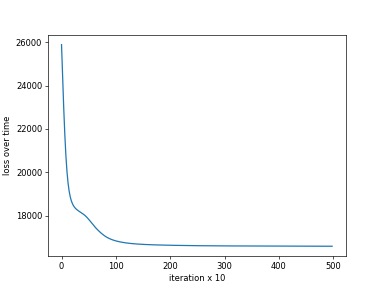

Final loss on Task 1: 
tensor(16583.1094, device='cuda:0', grad_fn=<AddBackward0>)


In [42]:
%matplotlib notebook
plt.figure()
plt.plot(loss_rolling[1:])
plt.ylabel('loss over time')
plt.xlabel('iteration x 10')
plt.show()

print('Final loss on Task 1: ')
print(loss_rolling[-1])

In [24]:
del tensor
# del core
del factors
del rec

NameError: name 'factors' is not defined

In [ ]:
del optimizer
del loss

In [11]:
import gc
gc.collect()

111

In [14]:
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


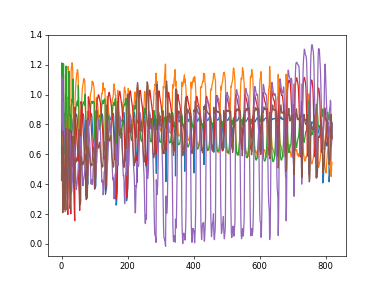

<IPython.core.display.Javascript object>


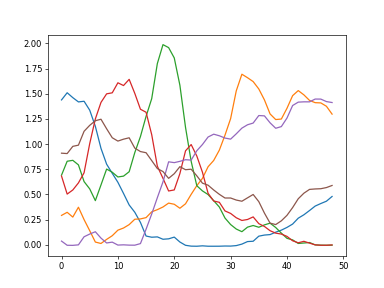

<IPython.core.display.Javascript object>


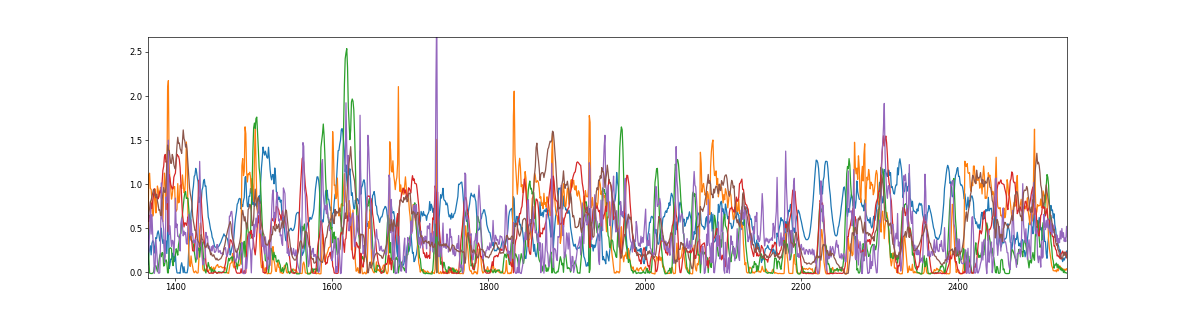

<IPython.core.display.Javascript object>


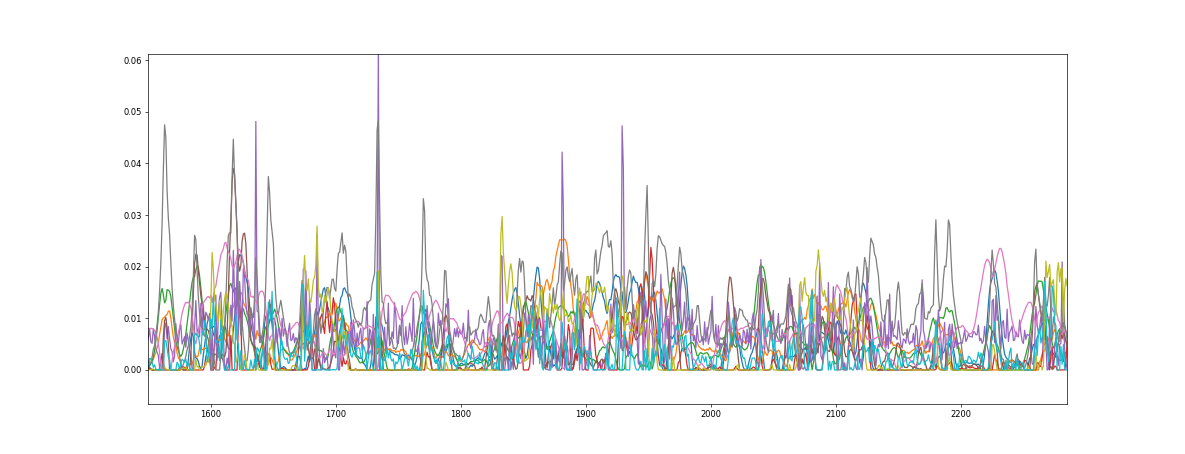

<IPython.core.display.Javascript object>


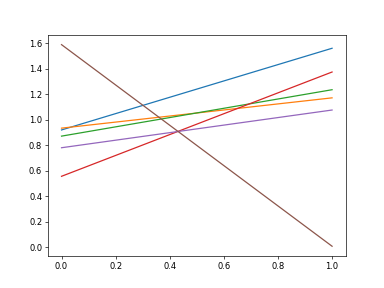

In [44]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.plot(ntf_obj.factors1.cpu().detach().numpy())
plt.figure()
plt.plot(ntf_obj.factors2.cpu().detach().numpy())
plt.figure()
plt.plot(ntf_obj.factors3.cpu().detach().numpy()[:,:])
plt.figure()
plt.plot(factors_np[2])
plt.figure()
plt.plot(ntf_obj.factors4.cpu().detach().numpy())

In [45]:
# del tensor
# # del core
# del factors
# del rec

# del rec_error

# del optimizer
# del loss

# import gc
# gc.collect()

In [177]:
torch.cuda.empty_cache()

In [ ]:
# import time

# n_iter = 1000
# lr = 0.05
# penalty = 0.1

# prox_plus = nn.Threshold(0,0) ## to make all output postive 

# optimizer = torch.optim.Adam(factors, lr=lr)

# tic = time.time()
# for i in range(1, n_iter):
#     print(f'hi {i}')
#     # Important: do not forget to reset the gradients
#     optimizer.zero_grad()

#     # Reconstruct the tensor from the decomposed form
# #     rec = tucker_to_tensor((core, factors))
#     rec = prox_plus(tl.cp_tensor.cp_to_tensor((weights, factors)))

#     # squared l2 loss
# #     loss = (tl.norm(rec - tensor, 2)).cpu().detach()
#     loss = tl.norm((rec - tensor), 2)

#     # squared l2 penalty on the factors of the decomposition
#     for f in factors:
#         loss = loss + penalty * f.pow(2).sum()

#     loss.backward()
#     optimizer.step()
    
# #     factors = np.abs(factors)

#     if i % 1 == 0:
#         toc = time.time()
#         print(round(toc-tic,2))
#         rec_error = tl.norm(rec.data - tensor.data, 2)/tl.norm(tensor.data, 2)
#         print("Epoch {},. Rec. error: {}".format(i, rec_error))
#         tic = time.time()